# Lale: Language for Automated Learning Exploration

Martin Hirzel, Kiran Kate, Avi Shinnar, Guillaume Baudart, and Pari Ram

27 March 2019

## Value Proposition

* Automation: facilitate automated search and composition of pipelines
* Portability: independent of library or programming language, cloud-ready
* Correctness: single source of truth, correct by construction, type-checked
* Usability: leverage sklearn mind-share, popularity, and codes

<img src="img/2019-0327-value.jpg" style="width:50%" align="left">

## Usability

To make Lale easy to learn and use, its APIs imitate those of
[sklearn](https://scikit-learn.org/), with init, fit, and predict,
and with pipelines. That said, Lale makes some careful changes
beyond sklearn to foster correctness.

In [1]:
from lale.datasets import load_iris_df
(X_train, y_train), (X_test, y_test) = load_iris_df()
print('truth  {}'.format(y_test.tolist()))

truth  [2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 1, 0]


In [2]:
from lale.lib.sklearn import LogisticRegression
trainable = LogisticRegression(LogisticRegression.solver.lbfgs, C=0.01)
trained = trainable.fit(X_train, y_train)
predictions = trained.predict(X_test)
print('actual {}'.format(predictions.tolist()))

actual [2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 0]


In [3]:
from sklearn.metrics import accuracy_score
print('accuracy {:.1%}'.format(accuracy_score(y_test, predictions)))

accuracy 76.7%


## Correctness

Lale uses [JSON Schema](https://json-schema.org/) to check for valid
hyperparameters. These schemas enable not just validation but also
interactive documentation. Thanks to using a single source of truth, the
documentation is correct by construction.

In [4]:
import jsonschema, sys
try:
    LogisticRegression(solver='adam', C=0.01)
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

Invalid configuration for LogisticRegression(solver='adam', C=0.01) due to invalid value solver=adam.
Schema of argument solver: {
    'description': 'Algorithm for optimization problem.',
    'enum': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'default': 'liblinear'}
Value: adam


In [5]:
LogisticRegression.hyperparam_schema('C')

{'description': 'Inverse regularization strength. Smaller values specify stronger regularization.',
 'type': 'number',
 'distribution': 'loguniform',
 'minimum': 0.0,
 'exclusiveMinimum': True,
 'default': 1.0,
 'minimumForOptimizer': 0.03125,
 'maximumForOptimizer': 32768}

In [6]:
print(LogisticRegression.hyperparam_defaults())

{'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'ovr', 'verbose': 0, 'warm_start': False, 'n_jobs': None}


## Automation

Lale can convert types to search spaces via a compiler from JSON Schema to
[hyperopt](http://hyperopt.github.io/hyperopt/). We are also
actively working towards various other forms of AI automation using various
other tools.

In [7]:
from lale.search.op2hp import hyperopt_search_space
import lale.helpers
from hyperopt import STATUS_OK, Trials, fmin, tpe, space_eval
import warnings
warnings.filterwarnings("ignore")

def objective(hyperparams):
    trainable = LogisticRegression(**lale.helpers.dict_without(hyperparams, 'name'))
    trained = trainable.fit(X_train, y_train)
    predictions = trained.predict(X_test)
    return {'loss': -accuracy_score(y_test, predictions), 'status': STATUS_OK}

search_space = hyperopt_search_space(LogisticRegression)

trials = Trials()
fmin(objective, search_space, algo=tpe.suggest, max_evals=10, trials=trials)
print('best accuracy {:.1%}'.format(-min(trials.losses())))
lale.helpers.print_yaml('best hyperparams', space_eval(search_space, trials.argmin))

100%|█████████████████████████| 10/10 [00:01<00:00,  7.58it/s, best loss: -1.0]
best accuracy 100.0%
best hyperparams:
  C: 17973.515333797495
  class_weight: balanced
  dual: false
  fit_intercept: true
  multi_class: ovr
  name: lale.lib.sklearn.logistic_regression.LogisticRegression
  penalty: l1
  solver: liblinear
  tol: 0.002593654542402462


## Portability

Lale is designed for portability across libraries, languages, and platforms
by:

* Embracing JSON Schema
* Minimizing direct code dependency on sklearn
* Discouraging in-place mutation of models

JSON Schema [implementations](https://json-schema.org/implementations.html):

<img src="img/2019-0327-portability.jpg" style="width:80%" align="left">

## Composition

Lale supports composite models, which resemble sklearn pipelines but are
more expressive.

* or (`|`) implements algorithmic choice
* pipe (`>>`) implements sequential composition
* and (`&`) implements parallel composition

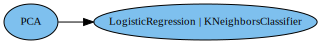

In [8]:
from lale.lib.sklearn import PCA
from lale.lib.sklearn import KNeighborsClassifier
optimizable = PCA >> (LogisticRegression | KNeighborsClassifier)
#optimizable = lale.operators.make_pipeline(PCA, LogisticRegression | KNeighborsClassifier)
lale.helpers.to_graphviz(optimizable)

In [9]:
from lale.lib.lale.hyperopt_classifier import HyperoptClassifier
optimizer = HyperoptClassifier(estimator=optimizable, max_evals=10)
trained = optimizer.fit(X_train, y_train)

100%|███████████| 10/10 [00:04<00:00,  2.65it/s, best loss: -0.949909090909091]


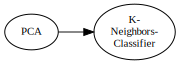

In [10]:
lale.helpers.to_graphviz(lale.helpers.best_estimator(trained))

## Input and Output Schemas

Besides schemas for hyperparameter, Lale also provides operator tags
and schemas for input and output data of operators.

In [11]:
LogisticRegression.get_tags()

{'pre': ['~categoricals'],
 'op': ['estimator', 'classifier', 'interpretable'],
 'post': ['probabilities']}

In [12]:
LogisticRegression.get_schema('input_fit')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Input data schema for training.',
 'type': 'object',
 'required': ['X', 'y'],
 'additionalProperties': False,
 'properties': {'X': {'description': 'Features; the outer array is over samples.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'y': {'description': 'Target class labels; the array is over samples.',
   'type': 'array',
   'items': {'type': 'number'}}}}

In [13]:
LogisticRegression.get_schema('output')

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'description': 'Output data schema for predictions (target class labels).',
 'anyOf': [{'description': 'For predict, class label.',
   'type': 'array',
   'items': {'type': 'number'}},
  {'description': 'For predict_proba, for each sample, vector of probabilities.',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}}]}

## Terminology

* An **operator** is a transformer or estimator and has **properties**.

* An operator can be an **individual operator** or a **pipeline**,
  which is a composite operator that has **elements**.

* The lifecycle **state** of an operator determines which properties
  are already bound and which are still free. There are four states:
  meta-model, planned, trainable, and trained.

Composition is orthogonal to lifecycle states.

<img src="img/2019-0327-terminology.jpg" style="width:70%" align="left">

## Related Work

* *Sklearn*. Incumbent for composition. Lale follows sklearn conventions
  and adds value for automation, portability, and correctness.

* *Hyperopt*. Incumbent for automation. Lale adds value for usability,
  portability, and correctness.

* *Kubeflow*. Platform for deployment and training. Lale is higher-level,
  could probably use Kubeflow as back-end.